In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


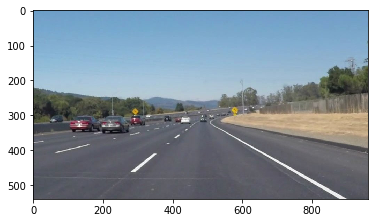

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteCurve.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

In [8]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    """
    By playing on the test images, I found out the range of slopes of the left and right lanes.
    Using the line equation y = mx + c, we are finding out the average slope(m) and 'c' values for 
    a given set of lines in a picture. To extrapolate the lines on the lanes, m and c values are used
    in the line equation with the corresponding y co-ordinartes(top and bottom co-ordinates of the preferred 
    lane area). if i > 0 condition is used to avoid a rare but possible 'division by zero error'.
    """
    """Right lane line"""
    
    m = 0
    c = 0
    i = 0
    a1 = 0
    a2 = 0   
   
    for line in lines:
        for x1,y1,x2,y2 in line:
            #print ((y2-y1)/(x2-x1))
            if ((y2-y1)/(x2-x1)) > 0.5 and ((y2-y1)/(x2-x1)) < 0.8:
                m = m + ((y2-y1)/(x2-x1))
                c = c + (y2 - ((y2-y1)/(x2-x1))*x2)
                i = i + 1
    if i > 0:
        m = m/i
        c = c/i
        a1 = (315 - c)/m
        a2 = (img.shape[0] - c)/m
        cv2.line(img, (int(a1), 315), (int(a2), img.shape[0]), color, thickness)
        
    """Left lane line"""
    
    m = 0
    c = 0
    i = 0
    a1 = 0
    a2 = 0
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #print ((y2-y1)/(x2-x1))
            if ((y2-y1)/(x2-x1)) > -0.9 and ((y2-y1)/(x2-x1)) < -0.5:
                  m = m + ((y2-y1)/(x2-x1))
                  c = c + (y2 - ((y2-y1)/(x2-x1))*x2)
                  i = i + 1
    if i > 0:
        m = m/i
        c = c/i
        #print (i)
        #print (m)
        a1 = (315 - c)/m
        a2 = (img.shape[0] - c)/m
        cv2.line(img, (int(a1), 315), (int(a2), img.shape[0]), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

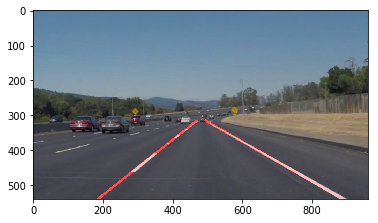

In [10]:
"""Core Pipeline"""
gray = grayscale(image)

kernel_size = 5
blur_gray = gaussian_blur(gray, kernel_size)

low_threshold = 50
high_threshold = 150
edges = canny(blur_gray, low_threshold, high_threshold)

imshape = image.shape
vertices = np.array([[(100,imshape[0]),(475, 315), (525, 315), (900,imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)

"""Increasing the threshold and min_line_len helped in getting rid of unnecessary small lines"""
rho = 1
theta = np.pi/180
threshold = 20
min_line_len = 100 
max_line_gap = 150
lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
            
lines_edges = weighted_img(lines, image, α=0.8, β=1., λ=0.)
plt.imshow(lines_edges)

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def process_image(image):
    gray = grayscale(image)

    kernel_size = 5
    blur_gray = gaussian_blur(gray, kernel_size)

    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)

    imshape = image.shape
    vertices = np.array([[(100,imshape[0]),(475, 315), (525, 315), (900,imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_len = 100
    max_line_gap = 150
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
                
    lines_edges = weighted_img(lines, image, α=0.8, β=1., λ=0.)
        
    return lines_edges 


white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:09<00:00, 24.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 10.3 s
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:31<00:00, 21.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 32.5 s


In [6]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:21<00:00, 11.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 24.3 s
